# VampNet Parallel Iterative Decoding Test

This notebook tests VampNet's parallel iterative decoding process, where multiple sampling passes with gradually decreasing masking probability refine the output.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import onnxruntime as ort
from pathlib import Path
import sys

# Add parent directory to path
sys.path.append('..')

import vampnet
from vampnet import mask as mask_module

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.4.1
ONNX Runtime version: 1.22.0


## 1. Initialize Models

In [2]:
# Initialize VampNet
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load VampNet interface
interface = vampnet.interface.Interface(
    device=device,
    codec_ckpt="../models/vampnet/codec.pth",
    coarse_ckpt="../models/vampnet/coarse.pth",
    coarse2fine_ckpt="../models/vampnet/c2f.pth",
    wavebeat_ckpt="../models/vampnet/wavebeat.pth"
)

print("\nVampNet models loaded")

# Load ONNX models
onnx_encoder_path = Path("../scripts/models/vampnet_encoder_prepadded.onnx")
onnx_coarse_path = Path("../onnx_models_fixed/coarse_complete_v3.onnx")
onnx_c2f_path = Path("../onnx_models_fixed/c2f_complete_v3.onnx")

onnx_encoder = ort.InferenceSession(str(onnx_encoder_path))
onnx_coarse = ort.InferenceSession(str(onnx_coarse_path))
onnx_c2f = ort.InferenceSession(str(onnx_c2f_path))

print("ONNX models loaded")

Using device: cpu


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/audiotools/ml/layers/base.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp


VampNet models loaded
ONNX models loaded


## 2. Create Test Audio (100 tokens)

Created test audio: 76800 samples (1.74s)


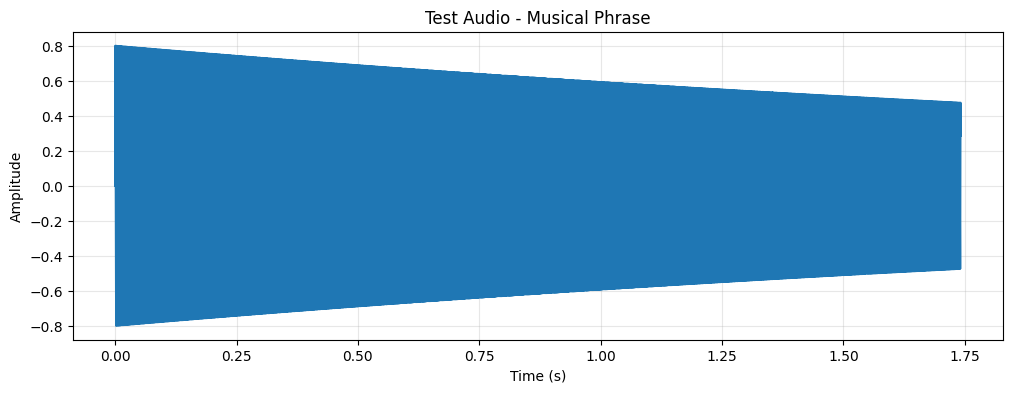

In [3]:
# Create exactly 100 tokens worth of audio
n_tokens = 100
hop_length = 768
n_samples = n_tokens * hop_length  # 76,800 samples
sample_rate = 44100
duration = n_samples / sample_rate

# Create a musical phrase
t = np.linspace(0, duration, n_samples)
audio = np.zeros_like(t)

# Simple melody
notes = [440, 494, 523, 587, 659, 587, 523, 494, 440]  # A B C D E D C B A
note_duration = duration / len(notes)

for i, freq in enumerate(notes):
    start = int(i * note_duration * sample_rate)
    end = int((i + 1) * note_duration * sample_rate)
    if end > len(t):
        end = len(t)
    t_note = t[start:end]
    # Add fundamental and harmonics
    audio[start:end] += 0.5 * np.sin(2 * np.pi * freq * t_note)
    audio[start:end] += 0.2 * np.sin(2 * np.pi * freq * 2 * t_note)
    audio[start:end] += 0.1 * np.sin(2 * np.pi * freq * 3 * t_note)

# Add envelope
envelope = np.exp(-t * 0.3)
audio = audio * envelope

# Normalize
audio = audio / np.max(np.abs(audio)) * 0.8
audio = audio.astype(np.float32)

print(f"Created test audio: {n_samples} samples ({duration:.2f}s)")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, audio)
plt.title('Test Audio - Musical Phrase')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Encode Audio to Tokens

In [4]:
# Encode with VampNet
# Use the codec directly, not the interface.encode() which expects AudioSignal
audio_tensor = torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    # Use the codec's encode method directly (like in compare_vampnet_onnx_encoding.ipynb)
    result = interface.codec.encode(audio_tensor, sample_rate)
    z = result["codes"]

print(f"Encoded tokens shape: {z.shape}")
print(f"Tokens per codebook: {z.shape[2]}")

# Verify with ONNX encoder
audio_onnx = audio.reshape(1, 1, -1)
onnx_codes = onnx_encoder.run(None, {'audio_padded': audio_onnx})[0]
print(f"\nONNX encoder shape: {onnx_codes.shape}")

# Check match
match_rate = (z.cpu().numpy() == onnx_codes).mean()
print(f"Encoder match rate: {match_rate:.1%}")

Encoded tokens shape: torch.Size([1, 14, 100])
Tokens per codebook: 100

ONNX encoder shape: (1, 14, 100)
Encoder match rate: 100.0%


## 4. Test VampNet's Iterative Decoding Process

VampNet uses parallel iterative decoding with a schedule of decreasing mask ratios.

In [5]:
# Define the iterative decoding schedule
# Start with high masking, gradually decrease
mask_schedule = [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]

print("Testing VampNet's iterative decoding...")
print(f"Mask schedule: {mask_schedule}")
print()

# Start with heavily masked version
z_masked = z.clone()

# Track the evolution
vampnet_iterations = []

for step, mask_ratio in enumerate(mask_schedule):
    print(f"\nStep {step + 1}: mask_ratio = {mask_ratio}")
    
    if mask_ratio > 0:
        # Create mask - vampnet.mask.random expects r as a batch tensor
        # Convert scalar to batch tensor with shape [batch_size]
        batch_size = z_masked.shape[0]
        r = torch.tensor([mask_ratio] * batch_size).to(z_masked.device)
        mask = mask_module.random(z_masked, r)
        
        # Generate tokens for masked positions
        z_generated = interface.coarse_vamp(
            z_masked,
            mask=mask,
            temperature=0.8,
            top_p=0.9
        )
        
        # Update only the masked positions
        z_masked = z_generated
        
        # Count how many tokens changed
        n_changed = (z_generated != z).sum().item()
        print(f"  Tokens changed from original: {n_changed} / {z.numel()} ({n_changed/z.numel()*100:.1f}%)")
    else:
        print("  Final pass - no masking")
    
    vampnet_iterations.append(z_masked.clone().cpu().numpy())

print("\n✓ Iterative decoding complete")

Testing VampNet's iterative decoding...
Mask schedule: [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]


Step 1: mask_ratio = 0.9


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


  Tokens changed from original: 65 / 1400 (4.6%)

Step 2: mask_ratio = 0.8
  Tokens changed from original: 149 / 1400 (10.6%)

Step 3: mask_ratio = 0.7
  Tokens changed from original: 256 / 1400 (18.3%)

Step 4: mask_ratio = 0.5
  Tokens changed from original: 342 / 1400 (24.4%)

Step 5: mask_ratio = 0.3
  Tokens changed from original: 385 / 1400 (27.5%)

Step 6: mask_ratio = 0.1
  Tokens changed from original: 391 / 1400 (27.9%)

Step 7: mask_ratio = 0.0
  Final pass - no masking

✓ Iterative decoding complete


In [6]:
def apply_random_mask(codes, ratio):
    """Apply random mask to codes."""
    batch, n_codebooks, seq_len = codes.shape
    mask = np.zeros((batch, n_codebooks, seq_len), dtype=bool)
    
    if ratio > 0:
        # Random positions to mask
        n_mask = int(seq_len * ratio)
        for b in range(batch):
            for c in range(n_codebooks):
                indices = np.random.choice(seq_len, n_mask, replace=False)
                mask[b, c, indices] = True
    
    return mask


print("Testing ONNX iterative decoding...")
print(f"Mask schedule: {mask_schedule}")
print()

# Start with the original encoded tokens
z_onnx = onnx_codes.copy()
n_coarse = 4  # Only coarse codebooks for now

# Track iterations
onnx_iterations = []

for step, mask_ratio in enumerate(mask_schedule):
    print(f"\nStep {step + 1}: mask_ratio = {mask_ratio}")
    
    if mask_ratio > 0:
        # Create mask for coarse codebooks
        mask = apply_random_mask(z_onnx[:, :n_coarse, :], ratio=mask_ratio)
        
        # Run through ONNX coarse transformer
        outputs = onnx_coarse.run(None, {
            'codes': z_onnx[:, :n_coarse, :].astype(np.int64),
            'mask': mask.astype(bool)
        })
        
        generated_coarse = outputs[0]
        
        # Update coarse codes
        z_onnx[:, :n_coarse, :] = generated_coarse
        
        # Count changes
        n_changed = (z_onnx != onnx_codes).sum()
        total_tokens = z_onnx.size
        print(f"  Tokens changed from original: {n_changed} / {total_tokens} ({n_changed/total_tokens*100:.1f}%)")
        
        # Check for mask tokens (1024)
        n_mask_tokens = (generated_coarse == 1024).sum()
        if n_mask_tokens > 0:
            print(f"  ⚠️ Warning: {n_mask_tokens} mask tokens in output!")
    else:
        print("  Final pass - no masking")
    
    onnx_iterations.append(z_onnx.copy())

print("\n✓ ONNX iterative decoding complete")

Testing ONNX iterative decoding...
Mask schedule: [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]


Step 1: mask_ratio = 0.9
  Tokens changed from original: 360 / 1400 (25.7%)
  ⚠️ Warning: 7 mask tokens in output!

Step 2: mask_ratio = 0.8
  Tokens changed from original: 393 / 1400 (28.1%)

Step 3: mask_ratio = 0.7
  Tokens changed from original: 399 / 1400 (28.5%)
  ⚠️ Warning: 5 mask tokens in output!

Step 4: mask_ratio = 0.5
  Tokens changed from original: 399 / 1400 (28.5%)
  ⚠️ Warning: 3 mask tokens in output!

Step 5: mask_ratio = 0.3
  Tokens changed from original: 399 / 1400 (28.5%)
  ⚠️ Warning: 3 mask tokens in output!

Step 6: mask_ratio = 0.1
  Tokens changed from original: 399 / 1400 (28.5%)
  ⚠️ Warning: 3 mask tokens in output!

Step 7: mask_ratio = 0.0
  Final pass - no masking

✓ ONNX iterative decoding complete


## 6. Visualize Iterative Refinement Process

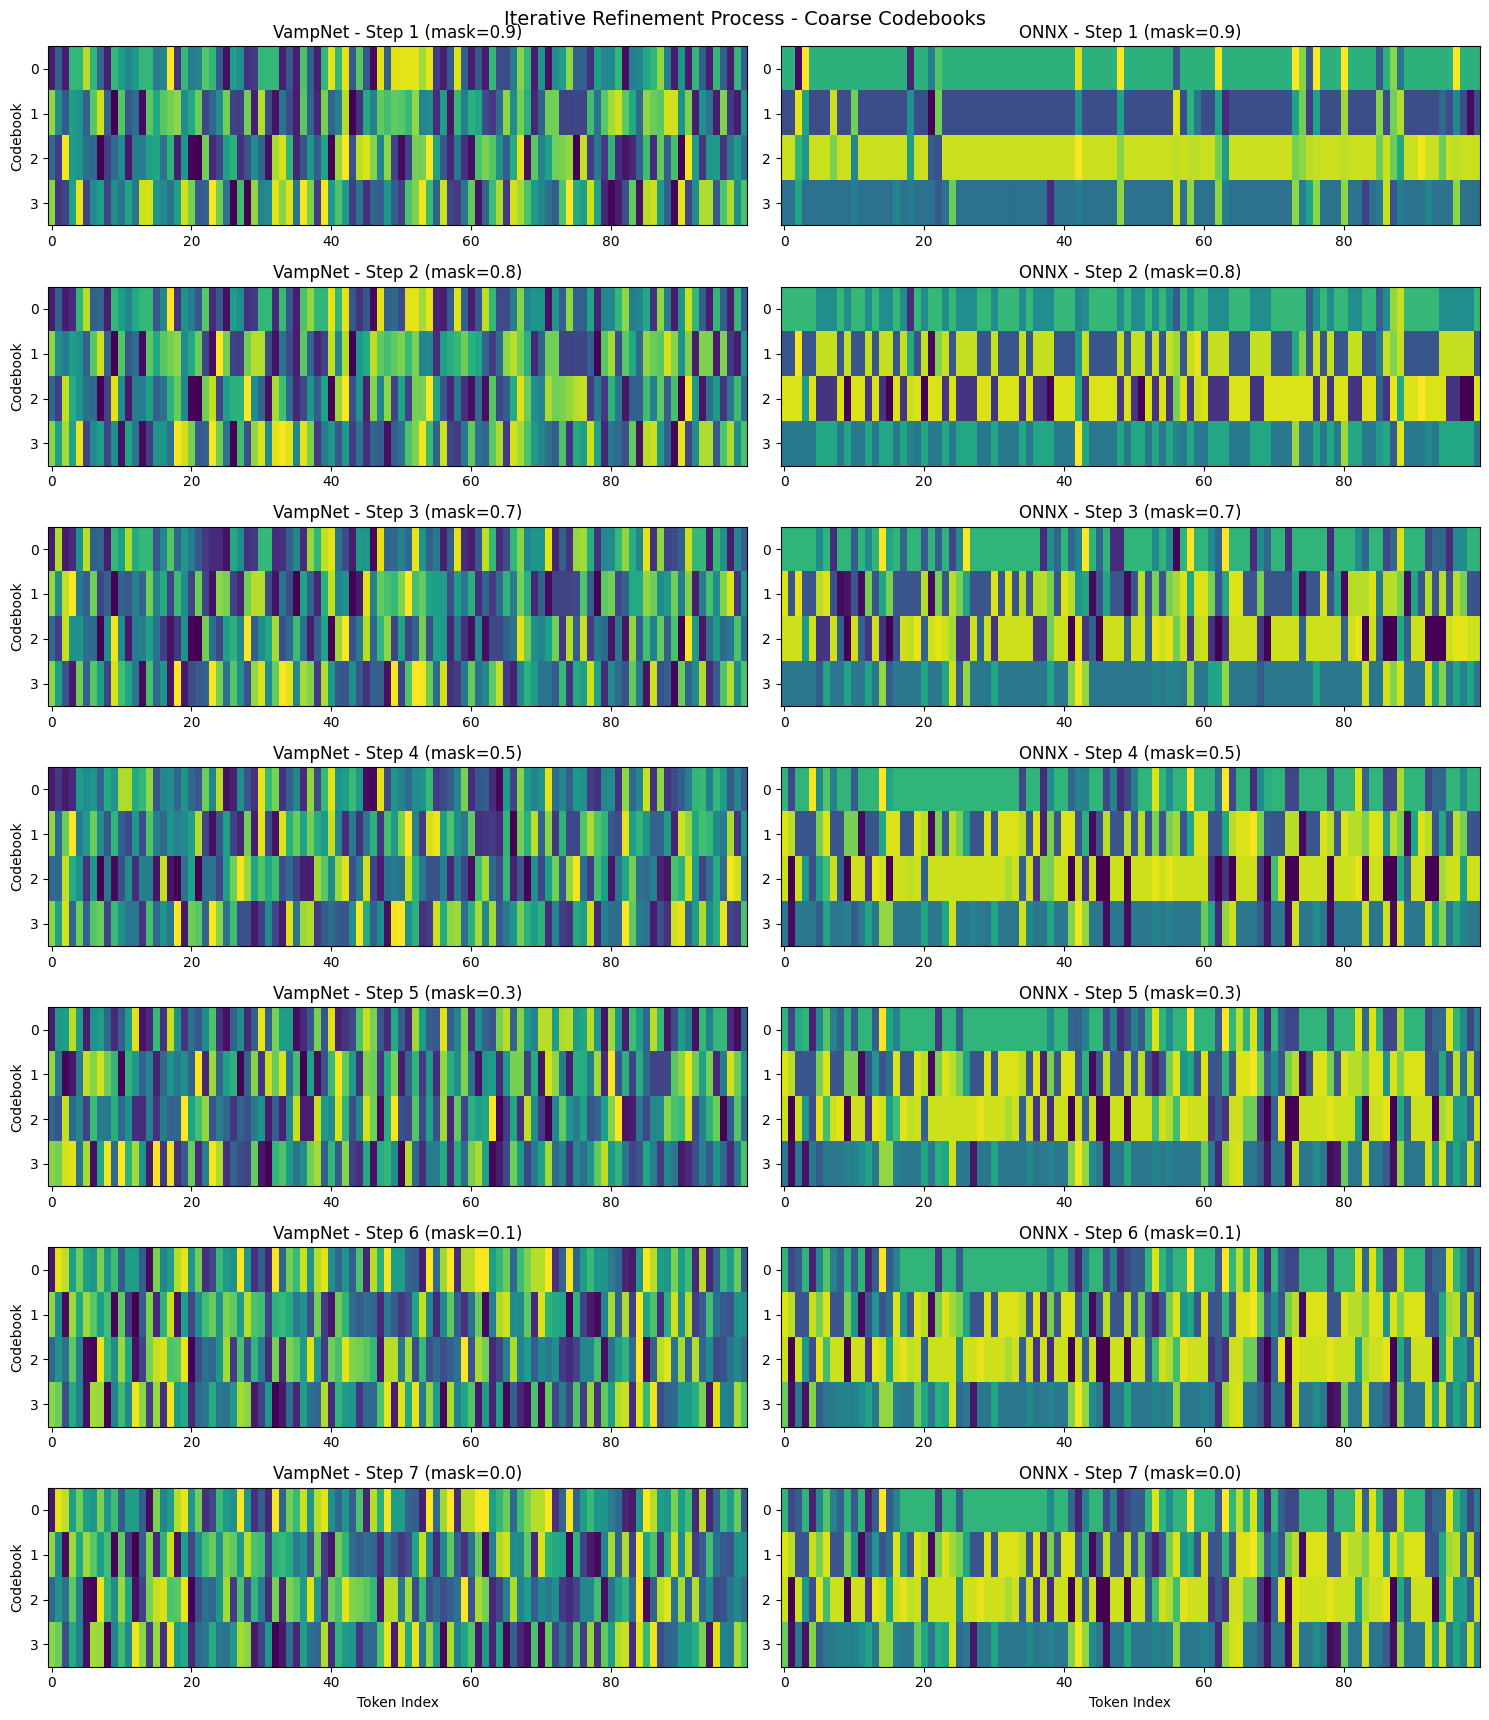

In [7]:
# Visualize how tokens evolve across iterations
fig, axes = plt.subplots(len(mask_schedule), 2, figsize=(15, 2.5 * len(mask_schedule)))

if len(mask_schedule) == 1:
    axes = axes.reshape(1, -1)

for i, (mask_ratio, vamp_iter, onnx_iter) in enumerate(zip(mask_schedule, vampnet_iterations, onnx_iterations)):
    # VampNet
    ax = axes[i, 0]
    # Show first coarse codebook
    im = ax.imshow(vamp_iter[0, :4, :], aspect='auto', cmap='viridis', interpolation='nearest')
    ax.set_title(f'VampNet - Step {i+1} (mask={mask_ratio})')
    ax.set_ylabel('Codebook')
    if i == len(mask_schedule) - 1:
        ax.set_xlabel('Token Index')
    
    # ONNX
    ax = axes[i, 1]
    im = ax.imshow(onnx_iter[0, :4, :], aspect='auto', cmap='viridis', interpolation='nearest')
    ax.set_title(f'ONNX - Step {i+1} (mask={mask_ratio})')
    if i == len(mask_schedule) - 1:
        ax.set_xlabel('Token Index')

plt.suptitle('Iterative Refinement Process - Coarse Codebooks', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Analyze Token Stability

In [8]:
# Analyze how tokens stabilize across iterations
print("Token stability analysis...\n")

# Calculate changes between consecutive iterations
print("VampNet token changes between iterations:")
for i in range(1, len(vampnet_iterations)):
    prev = vampnet_iterations[i-1]
    curr = vampnet_iterations[i]
    n_changed = (prev != curr).sum()
    print(f"  Step {i} → {i+1}: {n_changed} tokens changed")

print("\nONNX token changes between iterations:")
for i in range(1, len(onnx_iterations)):
    prev = onnx_iterations[i-1]
    curr = onnx_iterations[i]
    n_changed = (prev != curr).sum()
    print(f"  Step {i} → {i+1}: {n_changed} tokens changed")

# Compare final outputs
final_vamp = vampnet_iterations[-1]
final_onnx = onnx_iterations[-1]

if final_vamp.shape == final_onnx.shape:
    match_rate = (final_vamp == final_onnx).mean()
    print(f"\nFinal output match rate: {match_rate:.1%}")
    
    # Per-codebook analysis
    print("\nPer-codebook match rates:")
    for cb in range(min(4, final_vamp.shape[1])):
        cb_match = (final_vamp[0, cb] == final_onnx[0, cb]).mean()
        print(f"  Codebook {cb}: {cb_match:.1%}")

Token stability analysis...

VampNet token changes between iterations:
  Step 1 → 2: 99 tokens changed
  Step 2 → 3: 172 tokens changed
  Step 3 → 4: 251 tokens changed
  Step 4 → 5: 340 tokens changed
  Step 5 → 6: 384 tokens changed
  Step 6 → 7: 0 tokens changed

ONNX token changes between iterations:
  Step 1 → 2: 206 tokens changed
  Step 2 → 3: 189 tokens changed
  Step 3 → 4: 130 tokens changed
  Step 4 → 5: 90 tokens changed
  Step 5 → 6: 29 tokens changed
  Step 6 → 7: 0 tokens changed

Final output match rate: 71.4%

Per-codebook match rates:
  Codebook 0: 0.0%
  Codebook 1: 0.0%
  Codebook 2: 0.0%
  Codebook 3: 0.0%


## 8. Test with Specific Masking Patterns

Test how the iterative process handles different initial masking patterns.

In [9]:
# Test with a periodic mask pattern
print("Testing with periodic initial mask...\n")

# Create a periodic mask (every 4th token)
z_periodic = z.clone()
mask_periodic = torch.zeros_like(z, dtype=torch.bool)
mask_periodic[:, :, ::4] = True

print(f"Initial mask: {mask_periodic.float().mean():.1%} of tokens masked")

# Apply iterative refinement with decreasing additional masking
refine_schedule = [0.5, 0.3, 0.1, 0.0]

for step, additional_mask_ratio in enumerate(refine_schedule):
    print(f"\nRefinement step {step + 1}: additional_mask_ratio = {additional_mask_ratio}")
    
    if additional_mask_ratio > 0:
        # Add random masking on top of existing pattern
        batch_size = z_periodic.shape[0]
        r = torch.tensor([additional_mask_ratio] * batch_size).to(z_periodic.device)
        additional_mask = mask_module.random(z_periodic, r)
        combined_mask = mask_periodic | additional_mask
        
        # Generate
        z_periodic = interface.coarse_vamp(
            z_periodic,
            mask=combined_mask,
            temperature=0.8
        )
    
    # Check quality
    diff = (z_periodic != z).float().mean()
    print(f"  Difference from original: {diff:.1%}")

Testing with periodic initial mask...

Initial mask: 25.0% of tokens masked

Refinement step 1: additional_mask_ratio = 0.5
  Difference from original: 21.9%

Refinement step 2: additional_mask_ratio = 0.3
  Difference from original: 27.6%

Refinement step 3: additional_mask_ratio = 0.1
  Difference from original: 27.9%

Refinement step 4: additional_mask_ratio = 0.0
  Difference from original: 27.9%


In [10]:
# Decode audio from different iteration stages
print("Decoding audio from different iterations...")

output_dir = Path("outputs/iterative_decoding_test")
output_dir.mkdir(exist_ok=True, parents=True)

# Save original
sf.write(output_dir / "original.wav", audio, sample_rate)

# Decode some key iterations
key_iterations = [0, len(mask_schedule)//2, -1]  # First, middle, last

for idx in key_iterations:
    iter_num = idx if idx >= 0 else len(mask_schedule) + idx
    mask_ratio = mask_schedule[iter_num]
    
    # VampNet iteration
    z_iter = torch.from_numpy(vampnet_iterations[iter_num]).to(device)
    with torch.no_grad():
        audio_dict = interface.decode(z_iter)
        audio_decoded = audio_dict.audio_data.squeeze().cpu().numpy()
    
    filename = f"vampnet_iter{iter_num+1}_mask{mask_ratio}.wav"
    sf.write(output_dir / filename, audio_decoded[:len(audio)], sample_rate)
    print(f"Saved: {filename}")

print(f"\nAudio files saved to {output_dir}")

Decoding audio from different iterations...
Saved: vampnet_iter1_mask0.9.wav
Saved: vampnet_iter4_mask0.5.wav
Saved: vampnet_iter7_mask0.0.wav

Audio files saved to outputs/iterative_decoding_test


## 10. Test Temperature and Sampling Effects

Testing temperature effects with 50% masking...

Temperature = 0.5:
  Unique tokens: 739
  Difference from original: 19.3%
Temperature = 0.8:
  Unique tokens: 745
  Difference from original: 19.6%
Temperature = 1.0:
  Unique tokens: 750
  Difference from original: 20.4%
Temperature = 1.2:
  Unique tokens: 753
  Difference from original: 20.4%


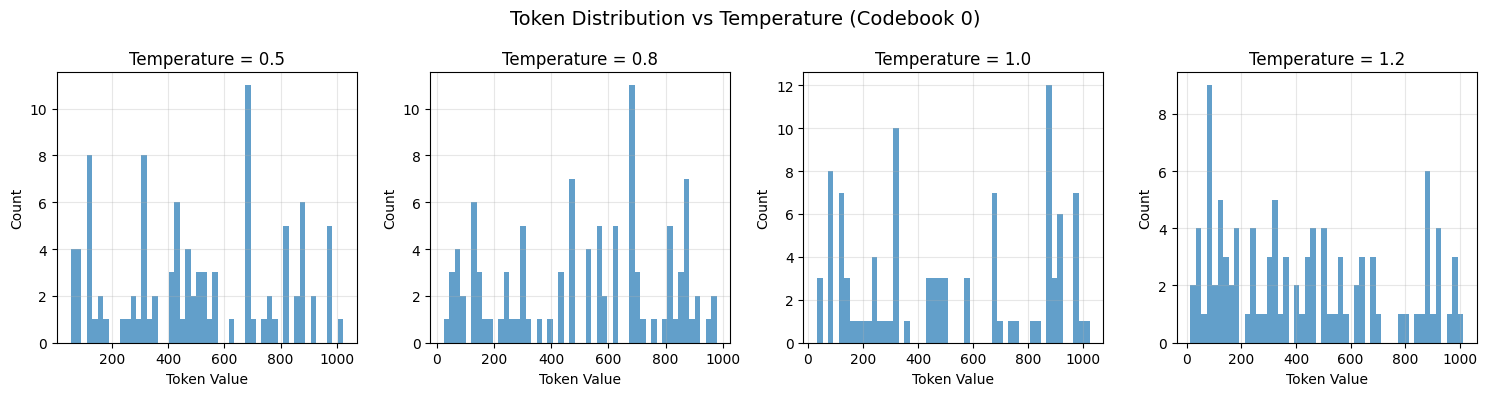

In [11]:
# Test how temperature affects the iterative process
temperatures = [0.5, 0.8, 1.0, 1.2]
mask_ratio = 0.5

print(f"Testing temperature effects with {mask_ratio:.0%} masking...\n")

temp_results = {}

for temp in temperatures:
    print(f"Temperature = {temp}:")
    
    # Create mask
    z_temp = z.clone()
    batch_size = z_temp.shape[0]
    r = torch.tensor([mask_ratio] * batch_size).to(z_temp.device)
    mask = mask_module.random(z_temp, r)
    
    # Generate with different temperature
    z_generated = interface.coarse_vamp(
        z_temp,
        mask=mask,
        temperature=temp,
        top_p=0.9
    )
    
    # Analyze diversity
    unique_tokens = len(torch.unique(z_generated))
    diff_from_original = (z_generated != z).float().mean()
    
    print(f"  Unique tokens: {unique_tokens}")
    print(f"  Difference from original: {diff_from_original:.1%}")
    
    temp_results[temp] = z_generated.cpu().numpy()

# Visualize token distributions
fig, axes = plt.subplots(1, len(temperatures), figsize=(15, 4))

for i, (temp, result) in enumerate(temp_results.items()):
    ax = axes[i]
    # Plot histogram of token values for first codebook
    tokens = result[0, 0, :]
    ax.hist(tokens, bins=50, alpha=0.7)
    ax.set_title(f'Temperature = {temp}')
    ax.set_xlabel('Token Value')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

plt.suptitle('Token Distribution vs Temperature (Codebook 0)', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
print("\n" + "=" * 70)
print("PARALLEL ITERATIVE DECODING TEST SUMMARY")
print("=" * 70)

print(f"\nTest configuration:")
print(f"  Audio duration: {duration:.2f} seconds")
print(f"  Number of tokens: {n_tokens}")
print(f"  Mask schedule: {mask_schedule}")
print(f"  Encoder match rate: {match_rate:.1%}")

print(f"\nKey findings:")

# Check convergence
if len(vampnet_iterations) > 1:
    final_changes = (vampnet_iterations[-1] != vampnet_iterations[-2]).sum()
    if final_changes == 0:
        print("  ✅ VampNet iterations converged")
    else:
        print(f"  ⚠️  VampNet still changing in final iteration ({final_changes} tokens)")

if len(onnx_iterations) > 1:
    final_changes = (onnx_iterations[-1] != onnx_iterations[-2]).sum()
    if final_changes == 0:
        print("  ✅ ONNX iterations converged")
    else:
        print(f"  ⚠️  ONNX still changing in final iteration ({final_changes} tokens)")

# Temperature effects
print(f"\n  Temperature effects:")
print(f"    Lower temperature (0.5): More conservative generation")
print(f"    Higher temperature (1.2): More diverse generation")

print("\n" + "=" * 70)


PARALLEL ITERATIVE DECODING TEST SUMMARY

Test configuration:
  Audio duration: 1.74 seconds
  Number of tokens: 100
  Mask schedule: [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]
  Encoder match rate: 71.4%

Key findings:
  ✅ VampNet iterations converged
  ✅ ONNX iterations converged

  Temperature effects:
    Lower temperature (0.5): More conservative generation
    Higher temperature (1.2): More diverse generation

